In [35]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import nltk
import statistics
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [36]:
shower_dp = 'data/Showerthoughts.csv'
shower_data = pd.read_csv(shower_dp,header=0)

In [37]:
shower_data = shower_data.drop(['domain', 'score', 'domain', 'permalink', 'over_18','link_flair_css_class',
       'author_flair_css_class', 'selftext','thumbnail', 'name', 'url', 'subreddit_id', 'edited', 'is_self', 'link_flair_text','distinguished','author_flair_css_class' ], axis='columns')

shower_data["engagement"] = shower_data["ups"] + shower_data["downs"] + shower_data["num_comments"]

In [38]:
tweets = shower_data['title']

targets = np.array(shower_data['ups'])
eng_targets = np.array(shower_data["engagement"])

In [39]:
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

 # config values// Beginning of word embeddings
embed_size = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 25 # max number of words in a question to use


tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(tweets)
tweets = tokenizer.texts_to_sequences(tweets)


tweets = pad_sequences(tweets, maxlen=maxlen)
print(len(tweets))
text_df = pd.DataFrame(tweets, shower_data["id"] )
text_df=text_df.rename(columns={1:'1',              2:"2",              3:"3",              4:"4",
                    5:"5",              6:"6",              7:"7",              8:"8",
                    9:"9",             10:"10",             11:"11",             12:"12",
                   13:"13",             14:"14",             15:"15",             16:"16",
                   17:"17",             18:"18",             19:"19",             20:"20",
                   21:"21",             22:"22",             23:"23",             24:"24"})
shower_data = shower_data.merge(text_df, how='left', on='id')


1000


In [40]:
import nltk.sentiment 
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [41]:
def sentiment_to_df(titles):
    neg = []
    neu = []
    pos = []
    for t in titles:
        scores = sia.polarity_scores(t)
        neg.append(scores['neg'])
        neu.append(scores['neu'])
        pos.append(scores['pos'])
        
    return neg, neu, pos

In [42]:
neg, neu, pos = sentiment_to_df(shower_data['title'])
shower_data['neg'] = neg
shower_data['neu'] = neu
shower_data['pos'] = pos

In [45]:
shower_data.columns


Index([ 'created_utc',        'title',          'ups',        'downs',
       'num_comments',   'engagement',              0,            '1',
                  '2',            '3',            '4',            '5',
                  '6',            '7',            '8',            '9',
                 '10',           '11',           '12',           '13',
                 '14',           '15',           '16',           '17',
                 '18',           '19',           '20',           '21',
                 '22',           '23',           '24',          'neg',
                'neu',          'pos'],
      dtype='object')

In [44]:
shower_data = shower_data.drop((['id']), axis='columns')

features = shower_data.drop(['title','ups', 'downs', 'num_comments', 'engagement'], axis='columns')

print(features.columns)

Index(['created_utc',             0,           '1',           '2',
                 '3',           '4',           '5',           '6',
                 '7',           '8',           '9',          '10',
                '11',          '12',          '13',          '14',
                '15',          '16',          '17',          '18',
                '19',          '20',          '21',          '22',
                '23',          '24',         'neg',         'neu',
               'pos'],
      dtype='object')


In [12]:
import matplotlib.pyplot as plt
print(shower_data['ups'].quantile([0.25,0.5,0.75]))

0.25    109.0
0.50    174.5
0.75    391.5
Name: ups, dtype: float64


In [13]:
targets
def make_target_buckets(targets):
    new_targets = []
    for t in targets:
        if t > 391.5:
            new_targets.append(4)
        elif t > 174.5:
            new_targets.append(3)
        elif t > 109.0:
            new_targets.append(2) 
        else:
            new_targets.append(1)
    return new_targets
stat_targ_buckets = make_target_buckets(targets)


In [14]:
r = [1,2,3,4, 5]
np.histogram(stat_targ_buckets, bins=r)
# 32.7% dummy model accuracy 

(array([254, 246, 250, 250]), array([1, 2, 3, 4, 5]))

In [15]:
# test=test
X_train, X_val, y_train, y_val = train_test_split(features, stat_targ_buckets, test_size=.2, train_size=.8, random_state=None, shuffle=True, stratify=None)
# test = val
statX_train, statX_test, staty_train, staty_test = train_test_split(X_train, y_train, test_size=.2, train_size=.8, random_state=None, shuffle=True, stratify=None)


0.24375


/opt/pub/eb/apps/all/DavidsonJupyter/2021-common-GCCcore-10.2.0/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/pub/eb/apps/all/DavidsonJupyter/2021-common-GCCcore-10.2.0/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/pub/eb/apps/all/DavidsonJupyter/2021-common-GCCcore-10.2.0/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


<AxesSubplot:>

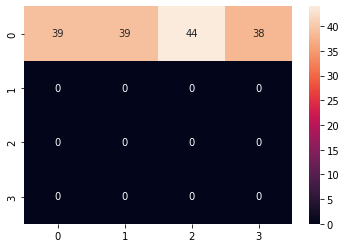

In [20]:
from sklearn.linear_model import LogisticRegression
logReg = LogisticRegression(random_state=0).fit(statX_train, staty_train)
preds = logReg.predict(statX_test)

print(logReg.score(statX_test, staty_test))
rfcCM = confusion_matrix(preds, staty_test)
sns.heatmap(rfcCM, annot=True)

/opt/pub/eb/apps/all/DavidsonJupyter/2021-common-GCCcore-10.2.0/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0.71875


/opt/pub/eb/apps/all/DavidsonJupyter/2021-common-GCCcore-10.2.0/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


<AxesSubplot:>

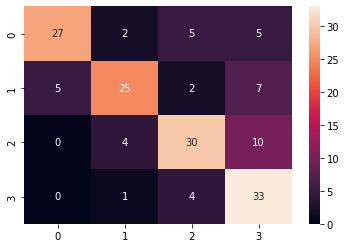

In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rfc = RandomForestClassifier(max_depth=None, random_state=36)
rfc.fit(statX_train, staty_train)
preds_rfc = rfc.predict(statX_test)
print(accuracy_score(staty_test, preds_rfc))

rfcCM = confusion_matrix(staty_test, preds_rfc)
sns.heatmap(rfcCM, annot=True)

0.24375


/opt/pub/eb/apps/all/DavidsonJupyter/2021-common-GCCcore-10.2.0/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/pub/eb/apps/all/DavidsonJupyter/2021-common-GCCcore-10.2.0/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


<AxesSubplot:>

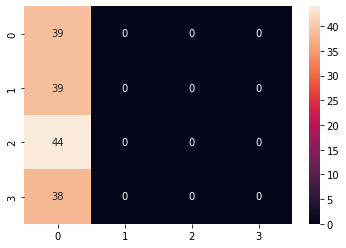

In [22]:
from sklearn.svm import SVC
clf= SVC(gamma='auto', C= 1, degree = 3, kernel = "rbf")
clf.fit(statX_train, staty_train)

preds2 = clf.predict(statX_test)
print(accuracy_score(staty_test, preds2))
rfcCM = confusion_matrix(staty_test, preds2)
sns.heatmap(rfcCM, annot=True)

0.775


/opt/pub/eb/apps/all/DavidsonJupyter/2021-common-GCCcore-10.2.0/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


<AxesSubplot:>

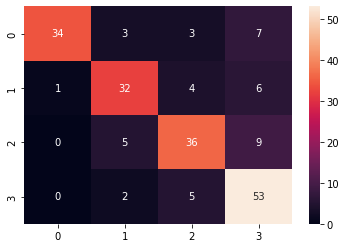

In [23]:
# test 
test = rfc.predict(X_val)
print(accuracy_score(y_val, test))

rfcCM = confusion_matrix(y_val, test)
sns.heatmap(rfcCM, annot=True)